In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
from tqdm.notebook import tqdm

import scipy.stats as scs
from scipy.special import comb
from statsmodels.stats.proportion import proportions_ztest

import how_to_ab_test.sample_data as sample_data
import how_to_ab_test.validation as validation

# How to AB Test

This lab explores how one goes about AB testing.

# Tests

### Fisher Exact Test


The Fisher exact test looks at the probability of this or more extreme a skew of success rates in a randomly drawn 2x2 contingency table conditioned on having the same marginals.

Let
<ul> 
    <li style="list-style-type: none;">$N$ &nbsp;&nbsp; be the total number of draws;</li>
    <li style="list-style-type: none;">$n$ &nbsp;&nbsp; the number of draws in Group 0;</li>
    <li style="list-style-type: none;">$K$ &nbsp;&nbsp; the total number of successes;</li>
</ul>

Then, conditioning on the marginals leaves a single degree of freedom. This can, WLOG, be taken to be
<ul>
    <li style="list-style-type: none;">$k$ &nbsp;&nbsp; the number of successes in Group 0;</li>
</ul>

Then, more extreme cases are $k > k_0$. (With the corresponding other $k < K-k_0$ for the two-sided test.)

For the probability of this table being drawn ($k = k$) given the marginals, consider the analogy to drawing without replacement $k$ balls of type 1 and $n-k$ of type 2 from an urn with $K$ of type 1 and $N-K$ of type 2.

To calculate this, we want the number of ways to draw the first row with the given split ($k$ out of $K$ from type 1 and $n-k$ from $N-K$) out of the possible ways to draw the first row ($n$ from a total $N$). (Note - having picked the first row, that fixes the whole table.)

So we get the hypergeometric distribution:
$$
P(t_{0,0} = k) = \frac{{K \choose k}{N-K \choose n-k}}{{N \choose n}}
$$

For the p-value of the Fisher exact test, we then just sum over values of $k$ that are as or more extreme than the observed one.

Implemented in `scipy.stats.fisher_exact`:

In [3]:
def fisher_exact(table):
    N = table.sum().sum()
    n = table.sum(axis=1)[0]
    K = table.sum(axis=0)[0]
    k = table.iloc[0, 0]

    num = 0
    for ki in range(k, K+1):
        num += comb(K, ki, exact=True) * comb(N-K, n-ki, exact=True)

    return num / comb(N, n, exact=True)


for table in sample_data.random_contingency_tables_2x2(10, is_equal_p=True):
    odds_ratio, pvalue = scs.fisher_exact(table, alternative='greater')
    pvalue_ = fisher_exact(table)
    # print((pvalue, pvalue_))
    assert abs(pvalue-pvalue_)<1e-8

Follow Up: It looks very Bayes-like. Is there any interpretation along those lines?

### Large Sample Z Test

The z test is a large-sample approximation that the proportions in two groups are equal.

It uses the fact that, by the CLT (and in practice converging very quickly - see below), the natural estimator for the group proportion is roughly normal:

$$
\hat{p} := \frac{X}{n} \sim \mathcal{N}\Big(p, \frac{p(1-p)}{n}\Big)
$$

where $ X \sim Binom(p, n)$.

Note - It is a normal distribution, not a t. I haven't found a reference for this. Beyond that we are talking about large-sample (and so the t-test should be approximately normal anyways), I suspect that we have a normal distribution because the binomial is a single-parameter distribution so the extra degree of freedom for the SD doesn't exist in this case.

To test the null hypothesis that the two groups come from the same distribution, we consider:

$$
z := \hat{p_1} - \hat{p_2} \sim \mathcal{N}\big(0, \hat{s}^2 \big)
$$

where 

$$
\begin{align}
\hat{s}^2 &= Var(\hat{p}) \\
    &= Var(\hat{p_1}) + Var(\hat{p_2}) \\
    &= \frac{\hat{p_1}(1-\hat{p_1})}{n_1} + \frac{\hat{p_2}(1-\hat{p_2})}{n_2}
\end{align}
$$

called the Satterthwaite approximation or we can pool, under the null hypothesis, the groups when estimating the SD, giving the pooled approximation

$$
\begin{align}
\hat{s}^2 &= Var(\hat{p}) \\
    &= Var(\hat{p_1}) + Var(\hat{p_2}) \\
    &= \frac{\hat{p}(1-\hat{p})}{n_1} + \frac{\hat{p}(1-\hat{p})}{n_2} \\
    &= \hat{p}(1-\hat{p}) \Big( \frac{1}{n_1} + \frac{1}{n_2} \Big)
\end{align}
$$

where

$$
\hat{p} = \frac{n_1 p_1 + n_2 p_2}{n_1 + n_2} = \frac{x_1 + x_2}{n_1 + n_2}
$$

The usual one-sided or two-sided tests are then as usual. 

Implemented in `statsmodels.stats.proportion.proportions_ztest`:

In [4]:
def proportions_ztest_(table, *, pooled_approx=False):
    assert table.shape == (2, 2)

    s1, s2 = table.iloc[:, 0]
    n1, n2 = table.sum(axis=1)

    p1, p2 = s1 / n1, s2 / n2

    if pooled_approx:
        p = (s1 + s2) / (n1 + n2)
        v = p * (1 - p) * (1 / n1 + 1 / n2)
    else:
        v = p1 * (1 - p1) / n1 + p2 * (1 - p2) / n2

    if not v > 0:
        return np.nan, np.nan
    
    z_stat = (p1 - p2) / np.sqrt(v)

    return z_stat, scs.norm.sf(np.abs(z_stat)) * 2


for table in sample_data.random_contingency_tables_2x2(10, is_equal_p=True):
    z_stat, pvalue = proportions_ztest(
        table.Success, 
        table.Success+table.Fail, 
        alternative='two-sided',
        prop_var=False
    )
    z_stat_, pvalue_ = proportions_ztest_(table, pooled_approx=True) 
    # print((pvalue, pvalue_))
    assert (np.isnan(pvalue) and np.isnan(pvalue_)) or abs(pvalue-pvalue_)<1e-8

### Chi-Squared Test

This is a large-sample approximation that two multinominial distribution match. Note that, unlike the Fisher and Z tests, it is limited to 2-sided tests but applies for any number of categories and groups.

Given a multinomial sample 

$$
\begin{align}
    X &\sim Multinomial_k(n, \pi) \\
    P(X=x) &= \frac{n!}{x_1!...x_k!} \pi_1^{x_1} ... \pi_k^{x_k}
\end{align}
$$

it is shown that under $ H_0: \pi = \pi_0 $ we have

$$
X^2 = \sum_{i=1}^k \frac{(X_i - E_i)^2}{E_i} \sim \chi^2(k-1)
$$

where $ E_i = X_i * \pi_i $.

Extending to $g$ groups, we have

$$
X^2 = \sum_{cells} \frac{(X_i - E_i)^2}{E_i} = \sum_{i=1}^{k} \sum_{j=1}^g \frac{(X_i^{(g)}-E_i)^2}{E_i} \sim \chi^2\big((k-1)(g-1)\big)
$$

where $E_i$ is estimated by the category totals $ E_i = \sum_{j=1}^g X_i^{(g)}$

Because the test is applying a discrete observation against a continuous approximation, Yates proposed a continuity correction. This subtracts 0.5 from each absolute error before squaring. Subsequent authors have proposed other corrections.

Note: Cressie & Read extended this by remarking that this and a few other tests were related as special cases of a continuous family of the "power divergence" statistics:

$$
2n I^\lambda = \frac{2}{\lambda (\lambda + 1)} \sum_{i=1}^k X_i\Bigg( \Big(\frac{X_i}{E_i}\Big)^\lambda - 1 \Bigg)
$$

Note: This is a square of the normal approximation. So it (the uncorrected version) is exactly equivalent to the two-sided Z-test.

Implemented in `scipy.stats.chi2_contingency`:

In [5]:
def chi2_contingency(table):
    by_category = table.values.sum(axis=0, keepdims=True)
    pi = by_category/by_category.sum()
    by_group = table.values.sum(axis=1, keepdims=True)

    E = by_group*pi
    
    X2 = (np.square(table.values-E)/E).sum()
    
    dof = (table.shape[0]-1)*(table.shape[1]-1)
    
    return X2, 1.0 - scs.chi2.cdf(X2, dof), dof, E


n = 10
n_valid = 0
for table in sample_data.random_contingency_tables_2x2(n, is_equal_p=True):
    if not (table.sum(axis=0) == 0).any():
        # chi2_contingency invalid if any category has 0 observed
        n_valid += 1
        chi2, pvalue, dof, expected = scs.chi2_contingency(table.values, correction=False)
        chi2_, pvalue_, dof_, expected_ = chi2_contingency(table)
        # print((pvalue, pvalue_))
        assert abs(pvalue-pvalue_)<1e-8
# print((n_valid, n))       
assert n_valid > n/2

### Bayes

The Bayes approach, naturally, is rather different. 

We get a posterior distribution for the probabilities (say $p_A$ and $p_B$). From this, we have a few options:

1. Look at probabilities (eg $P(p_A > p_B)$)
2. Look at credible intervals (eg Highest Posterior Density region (HPD): ie the $100*(1-\alpha)$% HPD is the $R(f_\alpha) := \{x: f(x) > f_\alpha\}$ where $f_\alpha$ is the maximal such that $ P(R(f_\alpha)) >= \alpha$)
3. Look at an expected expected loss and apply a decision rule.

Indeed (up to chosing the prior) Bayes formula gives the full answer and it's up to the user to choose a decision rule. In this sense, this is the true answer. The only real downside is the computational difficulty. The real question is how the frequentist approaches compare.

   Success  Fail
0        0     8
1        2    11


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p2, p1]
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [00:06<00:00, 1300.68draws/s]
The acceptance probability does not match the target. It is 0.693125479404842, but should be close to 0.8. Try to increase the number of tuning steps.
/home/mark/projects/lab/how_to_ab_test/.venv/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/mark/projects/lab/how_to_ab_test/.venv/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p1,0.100,0.092,0.000,0.274,0.002,0.001,2686.0,2686.0,2179.0,1680.0,1.0
p2,0.201,0.102,0.036,0.382,0.002,0.001,2542.0,2542.0,2423.0,2189.0,1.0
p_diff,0.102,0.139,-0.165,0.364,0.003,0.002,2648.0,2486.0,2622.0,2771.0,1.0


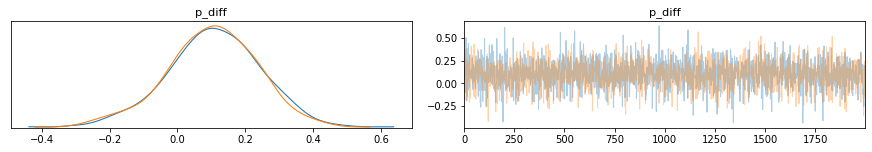

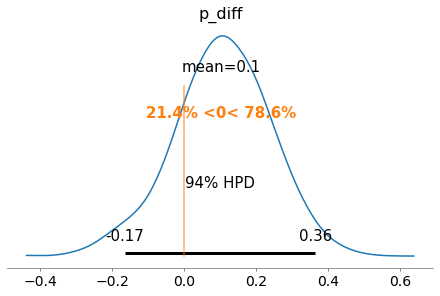

In [6]:
def bayes_2x2_contingency(table):
    n1, n2 = table.values.sum(axis=1)
    s1, s2 = table.iloc[:, 0]

    with pm.Model() as model:
        p1 = pm.Beta('p1', alpha=1, beta=1)
        p2 = pm.Beta('p2', alpha=1, beta=1)
        pm.Binomial('s1', n=n1, p=p1, observed=s1)
        pm.Binomial('s2', n=n2, p=p2, observed=s2)

        p_diff = pm.Deterministic('p_diff', p2-p1)

        trace=pm.sample(2000, tune=2000)

    return trace


table = sample_data.random_contingency_table_2x2()
print(table)

trace = bayes_2x2_contingency(table)
pm.traceplot(trace, var_names=['p_diff'])
pm.plot_posterior(trace, var_names=['p_diff'], ref_val=0.0)
pm.summary(trace)

# Validation

The key question is how the frequentist approximations hold up. In particular,

1. How close do the approximations match their intended significance levels?
2. How do their powers compare?

This will all be done in the context of 2-group / 2-outcome A/B tests, as this is common case across all the investigated tests.

To answer the first question, take $p_1 = p_2$ and consider the number of rejections vs $\alpha$ across a range of parameters:

In [7]:
rejections_type1 = pd.concat([
    validation.rejections(n=n, p1=p, p2=p, n_samples=10000, alphas=[0.5, 0.1, 0.05, 0.025, 0.01], exclude=[]).assign(n=n, p=p)
    for n in tqdm([10, 100, 1000], leave=False)
    for p in tqdm([0.01, 0.1, 0.25, 0.5, 0.9], leave=False)
])

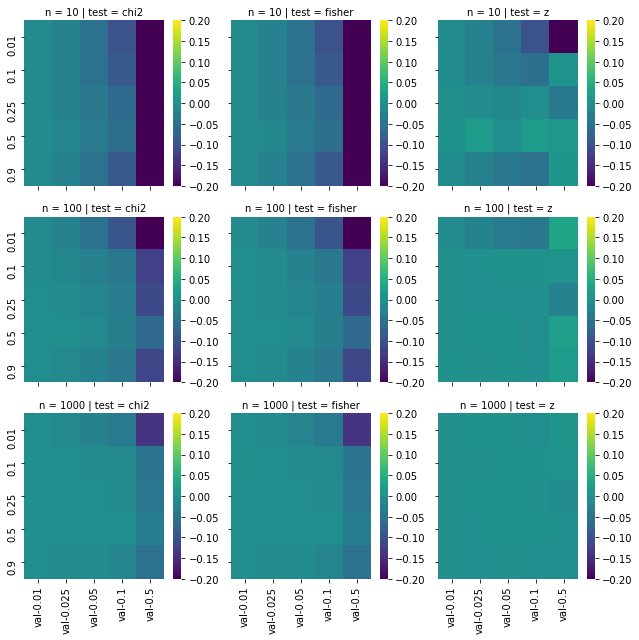

In [19]:
g = sns.FacetGrid(data=rejections_type1, row='n', col='test')
g.map_dataframe(validation.rejection_heatmap_by(row='p', col='alpha', diff_to_alpha=True))

From which the broad expected trends are observed:

* The accuracy improves as $n$ increases
* The accuracy improves as the confidence interval shrinks
* By $n = 1000$, all methods show high accuracy
* The uncorrected $\chi^2$ test is exactly the same as the z-test so omitted.

Some unexpected observations:

* The corrected $\chi^2$ test shows Type I error profile very similar to that of the Fisher test
* The Fisher (and corrected $\chi^2$ tests) seem less accurate for lower $n$ and the error is uniformly on the low side

These are addressed in https://www.jstor.org/stable/1164680 and https://www.jstor.org/stable/2681839. Confirming that indeed the corrected chi^2 for a 2x2 table with equal numbers in both groups approximates the Fisher exact tests.

To get a feel for the second question, consider the small-data case $n = 10$ across different values of the underlying probability and different factors by which the second group probability exceeds the first:

In [21]:
rejections_type2 = pd.concat([
    validation.rejections(n=10, p1=p, p2=p*factor, n_samples=10000, alphas=[0.5, 0.1, 0.05, 0.025, 0.01], exclude=[]).assign(p=p, factor=factor)
    for factor in tqdm([1.05, 1.1, 1.5], leave=False)
    for p in tqdm([0.01, 0.1, 0.25, 0.5], leave=False)
])

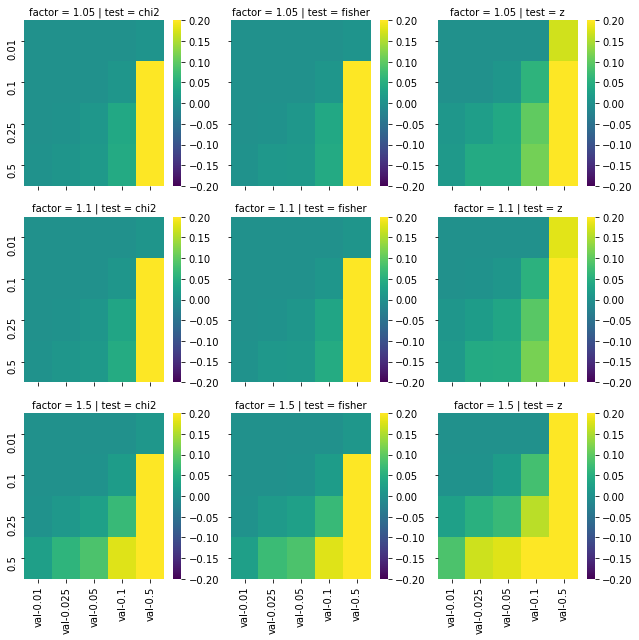

In [22]:
g = sns.FacetGrid(data=rejections_type2, row='factor', col='test')
g.map_dataframe(validation.rejection_heatmap_by(row='p', col='alpha'))

Again, the Fisher test compares very similarly to the corrected $\chi^2$ test. And again the z-test performs better on this metric. Though the results aren't exactly encouraging in any case - even where the second group probability is 50% greater than that of the first group, $H_0$ can only be rejected in about 20% of the cases.

# Conclusions

Generally, the results support that the z-test (similarly uncorrected $\chi^2$ if doing a 2-sided test) performs closer it's stated accuracy and gives higher power.

But ... See https://www.jstor.org/stable/1164680 and https://www.jstor.org/stable/2681839 for a discussion around the validity of the validation procedure. Particularly, these results depend very much on the underlying generation process assumed. Even in this frequentist framework, it's impossible to escape this model selection issue. 

# References

### Tests

https://www.itl.nist.gov/div898/handbook/prc/section3/prc33.htm

https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/PASS/Tests_for_Two_Proportions.pdf

https://www.jstor.org/stable/2983604

https://towardsdatascience.com/the-math-behind-a-b-testing-with-example-code-part-1-of-2-7be752e1d06f

https://www.jstor.org/stable/2345686

https://cdn2.hubspot.net/hubfs/310840/VWO_SmartStats_technical_whitepaper.pdf

https://www.jstor.org/stable/1164680

https://www.jstor.org/stable/2681839


### Methodology

http://blog.analytics-toolkit.com/2017/statistical-significance-ab-testing-complete-guide/

https://www.analytics-toolkit.com/pdf/Efficient_AB_Testing_in_Conversion_Rate_Optimization_-_The_AGILE_Statistical_Method_2017.pdf

https://www.evanmiller.org/how-not-to-run-an-ab-test.html

https://www.chrisstucchio.com/blog/2015/dont_use_bandits.html